In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from planners.IPVisibilityPRM import VisPRM_ROI
from lectures.IPVISVisibilityPRM import visibilityPRMVisualize
from lectures.IPEnvironment import CollisionChecker
from environment import get_all_scenes
from utils.IPVISVisibilityPRM import custom_visibility_prm_visualize, plot_benchmark_results, visualize_prm_three_views
import time
import pandas as pd
from scipy.spatial.distance import euclidean


In [2]:
# ---- Konfiguration für VisPRM ----
config = {
    "ntry": 50,                  # Anzahl der Sichtbarkeits-Stichproben
    "prm_type": "lazy",          # 'lazy' oder 'basic'
    # Parameter für LazyPRM / BasicPRM (Optional, Standardwerte werden sonst genommen)
    "initialRoadmapSize": 30,
    "updateRoadmapSize": 15,
    "kNearest": 5,
    "maxIterations": 20,
    "radius": 5.0,
    "numNodes": 50
}

#---- Alle Szenen durchlaufen + Benchmark ----
scenes = get_all_scenes()
results = []


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Knoten im Pfad: 5


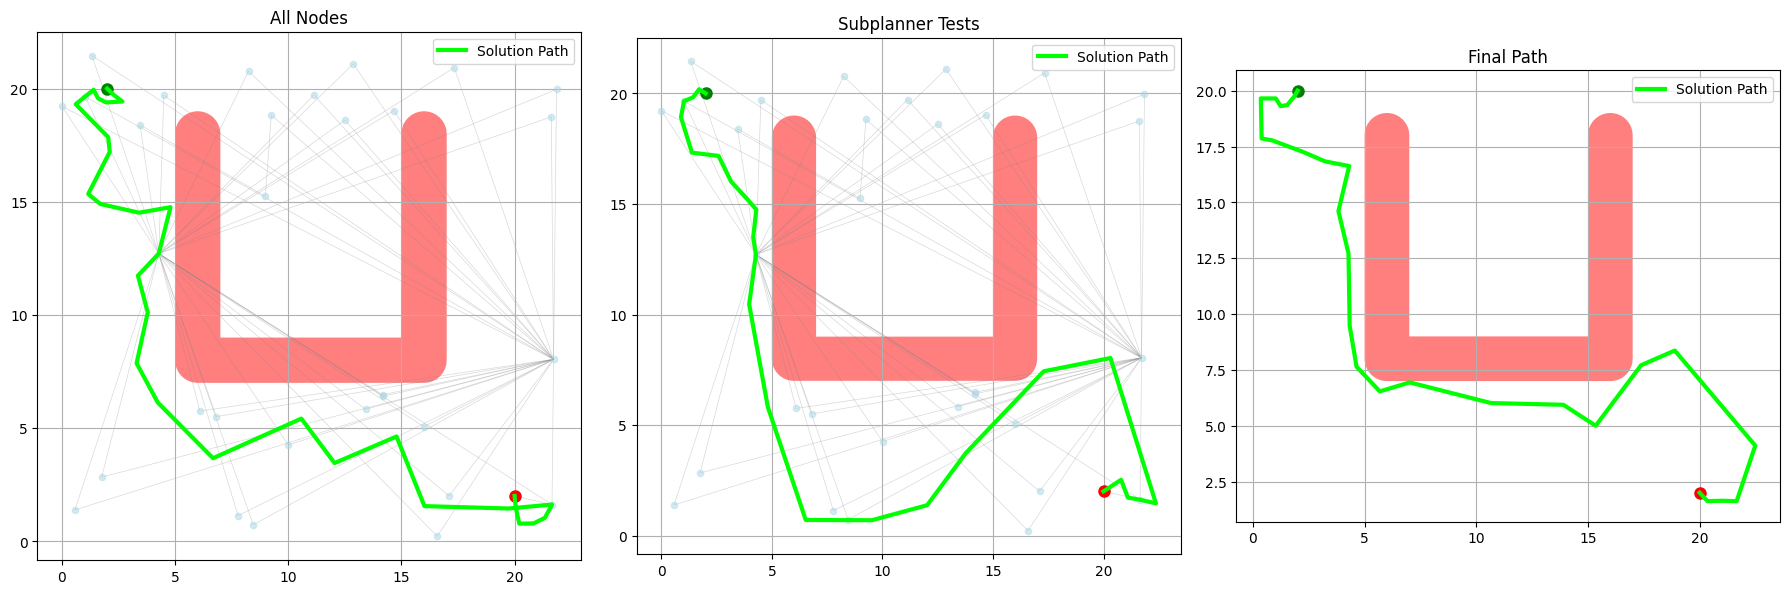


🔍 Szene: L-Shape
✅ Pfad gefunden in Szene: L-Shape, Knoten im Pfad: 4


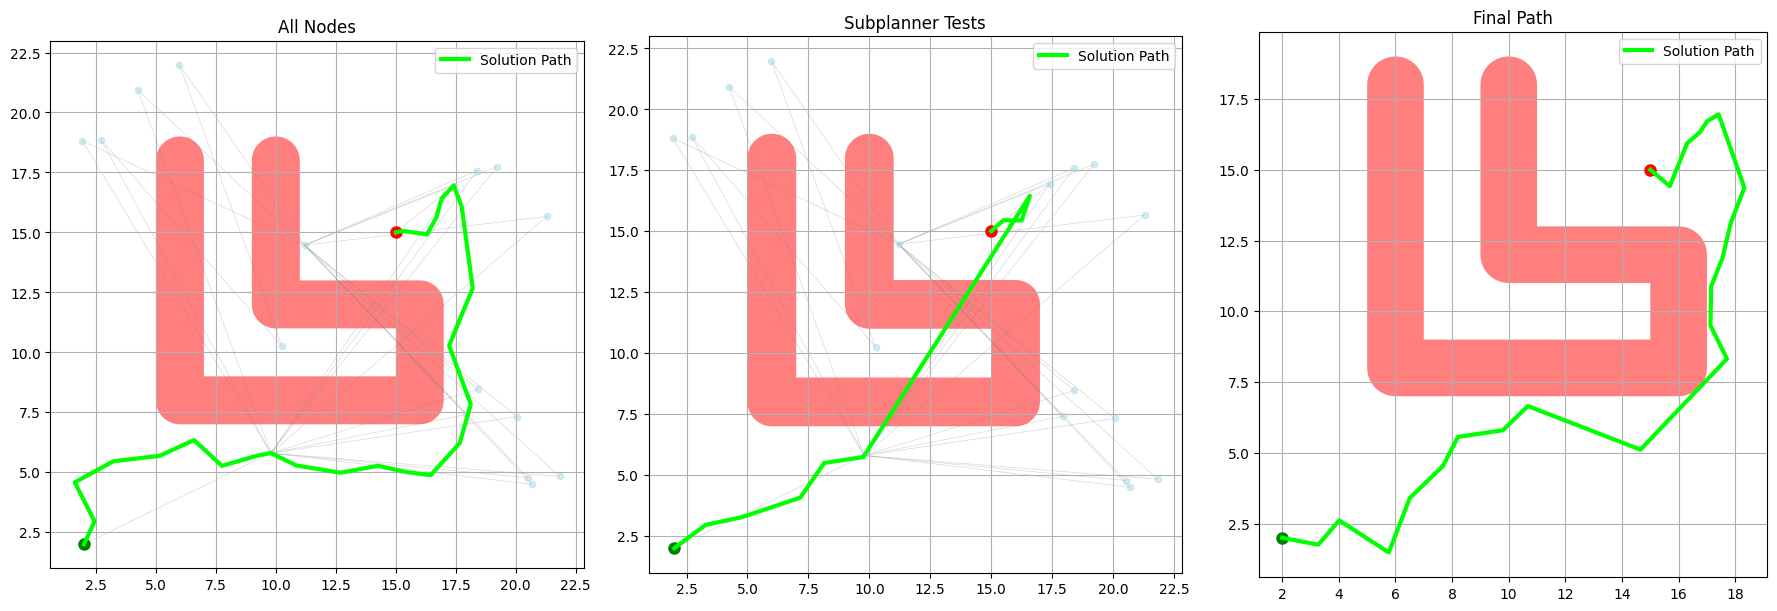


🔍 Szene: Corridor
✅ Pfad gefunden in Szene: Corridor, Knoten im Pfad: 6


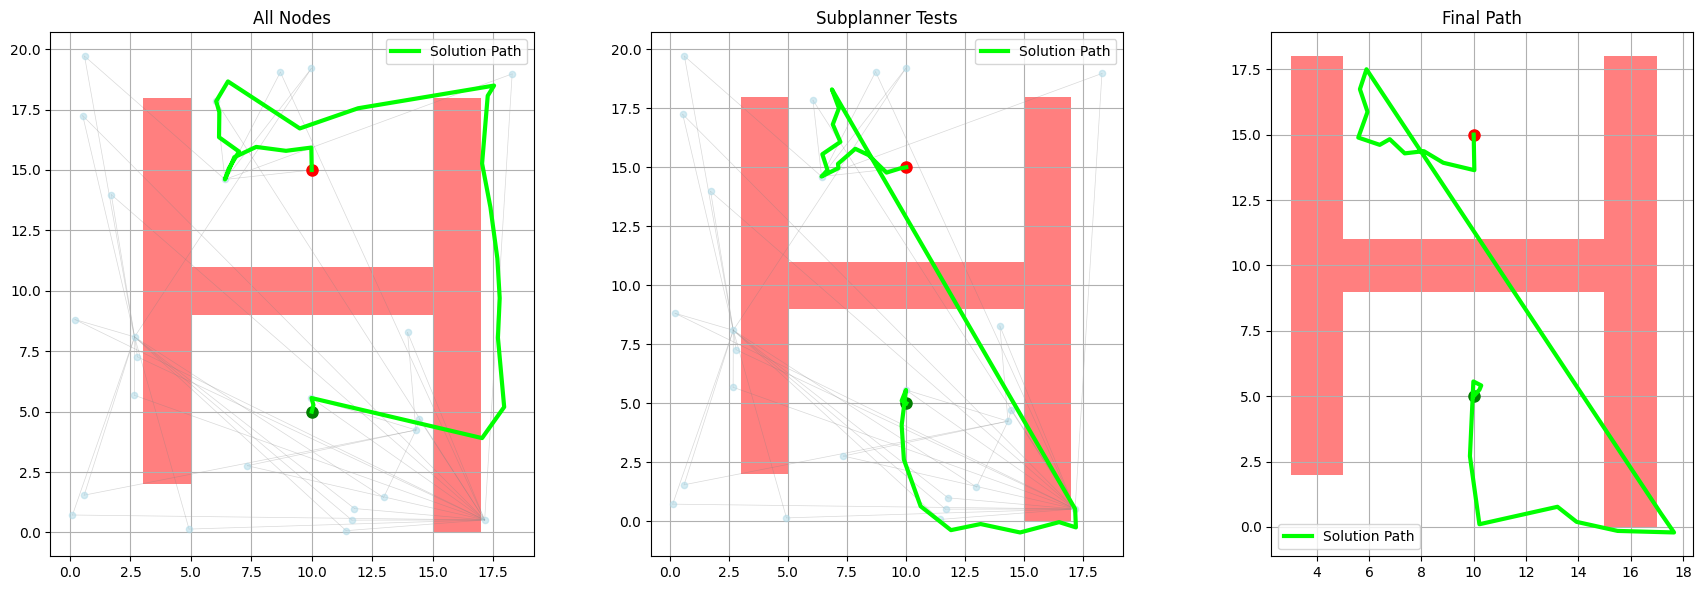


🔍 Szene: Complex Shape


KeyboardInterrupt: 

In [3]:
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal  = [list(goal_pos)]

    # CollisionChecker initialisieren
    collision_checker = CollisionChecker(scene, limits)

    # VisPRM initialisieren
    planner = VisPRM_ROI(collision_checker, prm_type=config["prm_type"])

    # Pfadplanung mit Zeitmessung
    t0 = time.time()
    path = planner.planPath(start, goal, config)
    t1 = time.time()

    # Koordinaten und Länge berechnen
    # neue Zeile: hole die "pos" jedes Knotens direkt aus dem Graph
    coords = [planner.graph.nodes[n]['pos'] for n in path] if path else []
    euclid_len = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Knoten im Pfad: {len(path)}")

    # Visualisierung
    fig, axs = visualize_prm_three_views(planner, path)
    # ggf. Start/Ziel noch hinzufügen:
    for ax in axs:
        ax.plot(start[0][0], start[0][1], 'go', ms=8)
        ax.plot(goal[0][0],  goal[0][1],  'ro', ms=8)
    plt.show()

    # Statistik
    result = {
        "scene": scene_name,
        "hasPath": bool(path),
        "path_nodes": len(path) if path else 0,
        "euclid_length": euclid_len,
        "time_s": t1 - t0,
        "nodes_total": len(planner.graph.nodes),
        "edges_total": len(planner.graph.edges),
        "roadmap_size": planner.graph.size()
    }
    results.append(result)

In [ ]:
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal  = [list(goal_pos)]

    # CollisionChecker initialisieren
    collision_checker = CollisionChecker(scene, limits)

    # VisPRM initialisieren
    planner = VisPRM(collision_checker, prm_type=config["prm_type"])

    # Pfadplanung mit Zeitmessung
    t0 = time.time()
    path = planner.planPath(start, goal, config)
    t1 = time.time()

    # Koordinaten und Länge berechnen
    # neue Zeile: hole die "pos" jedes Knotens direkt aus dem Graph
    coords = [planner.graph.nodes[n]['pos'] for n in path] if path else []
    euclid_len = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Knoten im Pfad: {len(path)}")

    # Visualisierung
    fig, ax = plt.subplots(figsize=(8, 8))
    visibilityPRMVisualize(planner, path, ax=ax)
    ax.set_title(f"VisPRM ({config['prm_type'].capitalize()}PRM) – {scene_name}")
    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0],  goal[0][1],  "ro", markersize=10, label="Ziel")
    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Statistik
    result = {
        "scene": scene_name,
        "hasPath": bool(path),
        "path_nodes": len(path) if path else 0,
        "euclid_length": euclid_len,
        "time_s": t1 - t0,
        "nodes_total": len(planner.graph.nodes),
        "edges_total": len(planner.graph.edges),
        "roadmap_size": planner.graph.size()
    }
    results.append(result)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

def custom_visibility_prm_visualize(prm, path, ax, draw_graph=True):
    """
    Zeichnet
      - die Hindernisse (prm._collisionChecker kennt Eure Szene)
      - optional die Visibility-Roadmap (Guard-Knoten + Kanten)
      - den gefundene Pfad (als echte Trajektorie)
    """
    # 1) Hindernisse
    # Eure CollisionChecker-Klasse muss hier ein paint()- oder draw()-Method haben,
    # sonst müsst ihr selbst Polygone aus prm._collisionChecker.scene holen.
    try:
        prm._collisionChecker.draw(ax)
    except AttributeError:
        # Fallback: nichts
        pass

    # 2) Visibility-Graph
    if draw_graph:
        pos = nx.get_node_attributes(prm.graph, 'pos')
        # Knoten
        xs, ys = zip(*pos.values())
        ax.scatter(xs, ys, s=20, c='lightblue', alpha=0.5, zorder=2)
        # Kanten
        for u, v in prm.graph.edges():
            p1, p2 = pos[u], pos[v]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]],
                    lw=0.5, c='gray', alpha=0.3, zorder=1)

    # 3) Gefundener Pfad
    if path:
        coords = prm.get_path_coordinates(path)
        if coords:
            xs, ys = zip(*coords)
            ax.plot(xs, ys, lw=3, c='lime', zorder=4, label='Solution Path')

    ax.set_aspect('equal')
    ax.grid(True)
    ax.legend()

# --- Beispiel-Aufruf ---
fig, ax = plt.subplots(figsize=(8,8))
custom_visibility_prm_visualize(planner, path, ax, draw_graph=False)
ax.plot(start[0][0], start[0][1], 'go', ms=10, label='Start', zorder=5)
ax.plot(goal[0][0],  goal[0][1],  'ro', ms=10, label='Ziel',  zorder=5)
ax.set_xlim(limits[0])
ax.set_ylim(limits[1])
plt.show()


In [ ]:
# ---- Run both variants ----
all_results = []

# LazyPRM version
lazy_results = run_benchmark(VisPRM_with_LazyPRM, "Hierarchical-LazyPRM")
lazy_df = pd.DataFrame(lazy_results)
lazy_df.to_csv(os.path.join(results_dir, "Hierarchical-LazyPRM_results.csv"), index=False)
all_results.extend(lazy_results)
